In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load CSV ---
df = pd.read_csv('./chart.csv', delimiter=',', dtype=str)
df['Date'] = pd.to_datetime(df['Data'].astype(str), format='%m.%Y')
df['Nominalny'] = df['Nominalny'].astype(float)
df['Prawdziwy'] = df['Prawdziwy'].astype(float)
df = df.sort_values('Date').reset_index(drop=True)
df

,Data,Nominalny,Prawdziwy,Date
0,09.2003,100.000000,100.000000,2003-09-01
1,10.2003,106.299851,106.622873,2003-10-01
2,11.2003,104.514056,104.645596,2003-11-01
3,12.2003,105.376345,105.574072,2003-12-01
4,01.2004,109.428674,109.318545,2004-01-01
...,...,...,...,...
245,02.2024,544.241670,333.548484,2024-02-01
246,03.2024,561.589103,342.347073,2024-03-01
247,04.2024,548.068925,335.742394,2024-04-01
248,05.2024,562.862424,343.575504,2024-05-01


In [39]:
returns = df['Nominalny'].pct_change().fillna(0).values
inflation_mult = df['Nominalny'] / df['Prawdziwy']

# --- 2. Calculate monthly deposits (inflation-adjusted) ---
base_deposit = 1000
monthly_deposit = base_deposit * inflation_mult.values

# Management fees per year (2003-2024) - % of capital
yearly_fees = {
    2003: 5.88, 2004: 6.08, 2005: 5.15, 2006: 4.13, 2007: 4.63,
    2008: 5.54, 2009: 3.88, 2010: 3.50, 2011: 4.13, 2012: 4.50,
    2013: 3.21, 2014: 2.00, 2015: 1.50, 2016: 1.50, 2017: 1.50,
    2018: 1.50, 2019: 1.50, 2020: 0.53, 2021: 1.17, 2022: 4.17,
    2023: 5.88, 2024: 5.75
}

fee_monthly = np.array([
    (yearly_fees.get(d.year, 0) * 0.19) / 100 / 12  # roczna fee * 19% podatek / 12 miesięcy
    for d in df['Date']
])
fee_monthly.astype(str)

array(['0.000931', '0.000931', '0.000931', '0.000931',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0009626666666666667', '0.0009626666666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0008154166666666667', '0.0008154166666666667',
       '0.0006539166666666667', '0.0006539166666666667',
       '0.0006539166666666667', '0.0006539166666666667',
       '0.0006539166666666667', '0.0006539166666666667',
       '0.0006539166666666667', '0.0006539166666666667',
       '0.0006539166666666667', '

In [172]:
np.random.seed(42)
future_years = 21
months_future = future_years * 12
n_paths = 4

simulated_returns = np.random.choice(returns[1:], size=(n_paths, months_future), replace=True)
simulated_returns

array([[-0.00117671,  0.01104463, -0.02011127, ..., -0.06304425,
        -0.01292553, -0.05541503],
       [-0.00914923,  0.00572854,  0.01649204, ...,  0.00572854,
         0.00841311, -0.00124684],
       [ 0.01736368, -0.03047636,  0.04363307, ..., -0.03207028,
         0.02348649,  0.0129794 ],
       [ 0.02307482, -0.01519602,  0.03417635, ..., -0.02419484,
         0.04363307,  0.01085288]], shape=(4, 252))

In [173]:
def simulate_strategy(x_months_account2):
    all_portfolios = []
    final_values = []
    depletion_months = []

    for path in simulated_returns:
        acc1 = 0.0
        acc2 = 0.0
        acc2_principal = 0.0
        depletion_month = None

        portfolio_history = []

        # --- Faza wpłat ---
        for i in range(len(df)):
            if i < x_months_account2:
                acc2 += monthly_deposit[i]
                acc2_principal += monthly_deposit[i]
            else:
                acc1 += monthly_deposit[i]

            acc1 *= (1 + returns[i])
            acc2 *= (1 + returns[i])
            acc1 *= (1 - fee_monthly[i])

            portfolio_history.append(acc1 + acc2)

        before_withdrawal = acc1 + acc2

        # --- Faza wypłat (4% z inflacją od before_withdrawal) ---
        for r in path:
            acc1 *= (1 + r)
            acc2 *= (1 + r)
            acc1 *= (1 - 0.001)  # 0.1% miesięcznie

            current_month = len(portfolio_history)

            if current_month % 12 == 0:
                years_passed = current_month // 12
                withdrawal = 0.04 * before_withdrawal * 1.02 ** years_passed

                if withdrawal <= acc1:
                    acc1 -= withdrawal
                else:
                    if depletion_month is None:
                        depletion_month = current_month

                    withdrawal_from_acc1 = acc1
                    acc1 = 0
                    withdrawal_from_acc2 = withdrawal - withdrawal_from_acc1

                    gain_share = max(0, (acc2 - acc2_principal) / acc2) if acc2 > 0 else 0
                    taxable_amount = withdrawal_from_acc2 * gain_share
                    tax = 0.19 * taxable_amount

                    acc2 -= (withdrawal_from_acc2 + tax)

                    principal_share = acc2_principal / (acc2 + withdrawal_from_acc2 + tax) if (acc2 + withdrawal_from_acc2 + tax) > 0 else 0
                    acc2_principal -= withdrawal_from_acc2 * principal_share
                    if acc2_principal < 0:
                        acc2_principal = 0

            total = acc1 + acc2
            if total <= 0:
                portfolio_history.append(0)
                break

            portfolio_history.append(total)

        final_values.append(acc1 + acc2)
        all_portfolios.append(portfolio_history)
        depletion_months.append(depletion_month)

    median_final = np.median(final_values)
    max_len = max(len(p) for p in all_portfolios)
    average_curve = np.mean(
        np.array([np.pad(p, (0, max_len - len(p)), 'edge') for p in all_portfolios]),
        axis=0
    )

    return median_final, average_curve, depletion_months


In [174]:
months_total = len(df)
best_value = -np.inf
best_curve = None
best_x = None
best_depletion_month = None

for x in range(months_total+1):
    val, curve, depletion = simulate_strategy(x)
    if val > best_value:
        best_value = val
        best_curve = curve
        best_depletion_month = depletion
        best_x = x

In [175]:
print(f"Optimal switch after {best_x} months (~{best_x/12:.1f} years). Final value: {best_value:,.2f}")
best_curve[250:260]

Optimal switch after 64 months (~5.3 years). Final value: 178,453.20


array([886606.82641319, 879463.19982935, 841670.05364669, 861067.71494628,
       875945.62544303, 877366.33278789, 900382.20091793, 913990.86041734,
       907118.00174628, 913165.08184742])

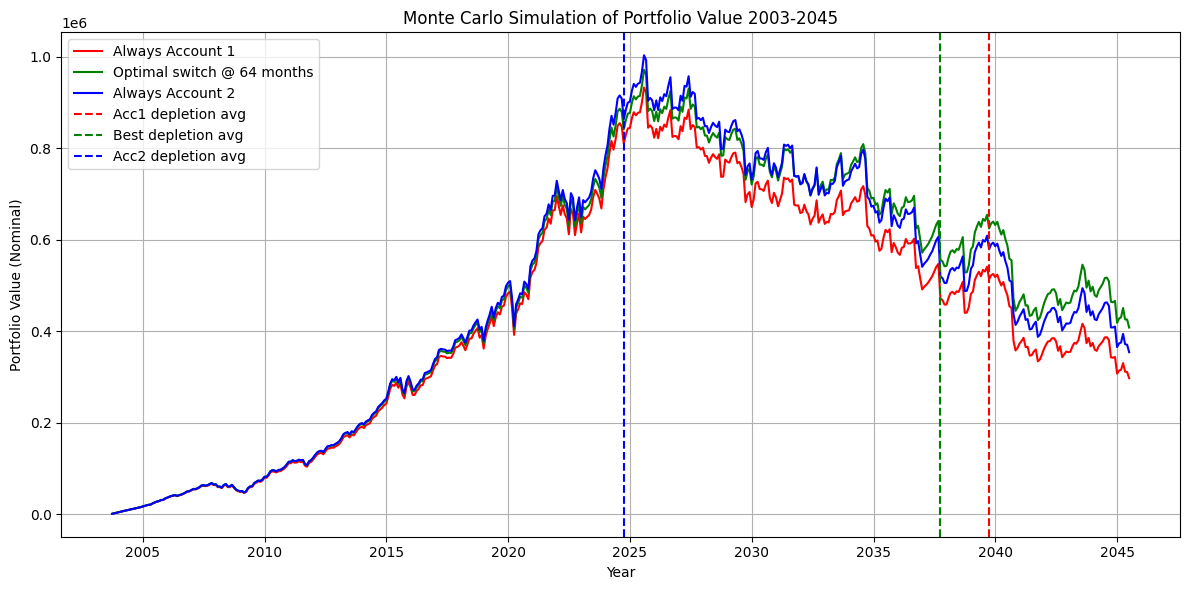

In [176]:
_, curve_acc1, depletion_acc1 = simulate_strategy(0)
_, curve_acc2, depletion_acc2 = simulate_strategy(months_total)

# Zamień miesiące na daty (średnie wyczerpanie)
import numpy as np
mean_depletion_month_acc1 = np.mean([m for m in depletion_acc1 if m is not None])
mean_depletion_month_acc2 = np.mean([m for m in depletion_acc2 if m is not None])
mean_depletion_month_best = np.mean([m for m in best_depletion_month if m is not None])

years = pd.date_range(start=df['Date'].iloc[0], periods=len(curve_acc1), freq='ME')

plt.figure(figsize=(12,6))
plt.plot(years, curve_acc1, label="Always Account 1", color="red")
plt.plot(years, best_curve, label=f"Optimal switch @ {best_x} months", color="green")
plt.plot(years, curve_acc2, label="Always Account 2", color="blue")

if not np.isnan(mean_depletion_month_acc1):
    plt.axvline(years[int(mean_depletion_month_acc1)], color='red', linestyle='--', label='Acc1 depletion avg')

if not np.isnan(mean_depletion_month_acc1):
    plt.axvline(years[int(mean_depletion_month_best)], color='green', linestyle='--', label='Best depletion avg')

if not np.isnan(mean_depletion_month_acc2):
    plt.axvline(years[int(mean_depletion_month_acc2)], color='blue', linestyle='--', label='Acc2 depletion avg')

plt.xlabel("Year")
plt.ylabel("Portfolio Value (Nominal)")
plt.title("Monte Carlo Simulation of Portfolio Value 2003-2045")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
